In [1]:
import glob
import pandas as pd
import re

# 📁 입력/출력 경로
input_pattern = "/home/avees/tee/output/gemm/gemm_arr_size*.csv"
output_file = "/home/avees/tee/output/gemm/all_gemm_stats.csv"

# 📂 모든 파일 불러오기
files = sorted(glob.glob(input_pattern))

# 결과 저장 리스트
results = []

for file_path in files:
    df = pd.read_csv(file_path)
    for col in df.columns:
        data = df[col].dropna()
        results.append({
            "label": col,
            "mean": data.mean(),
            "max": data.max(),
            "min": data.min(),
            "std": data.std(),
            "count": data.count()
        })

# 결과 DataFrame
stats_df = pd.DataFrame(results)

# ✅ 같은 라벨이 여러 파일에 있으면 평균 등으로 통합
stats_df = stats_df.groupby("label").agg({
    "mean": "mean",
    "max": "max",
    "min": "min",
    "std": "mean",
    "count": "sum"
}).reset_index()

# ✅ 숫자 추출 후 정렬 키 열 추가
def extract_num(label):
    nums = re.findall(r"\d+", label)
    return int(nums[0]) if nums else 999999

stats_df["sort_key"] = stats_df["label"].apply(extract_num)

# ✅ 숫자 기준 오름차순 정렬
stats_df = stats_df.sort_values(by="sort_key", ascending=True).drop(columns=["sort_key"]).reset_index(drop=True)

# 결과 저장
stats_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"✅ 통계 및 정렬 완료! 결과 저장: {output_file}")


✅ 통계 및 정렬 완료! 결과 저장: /home/avees/tee/output/gemm/all_gemm_stats.csv


✅ 그래프 저장 완료: /home/avees/tee/output/gemm/all_gemm_plot.png


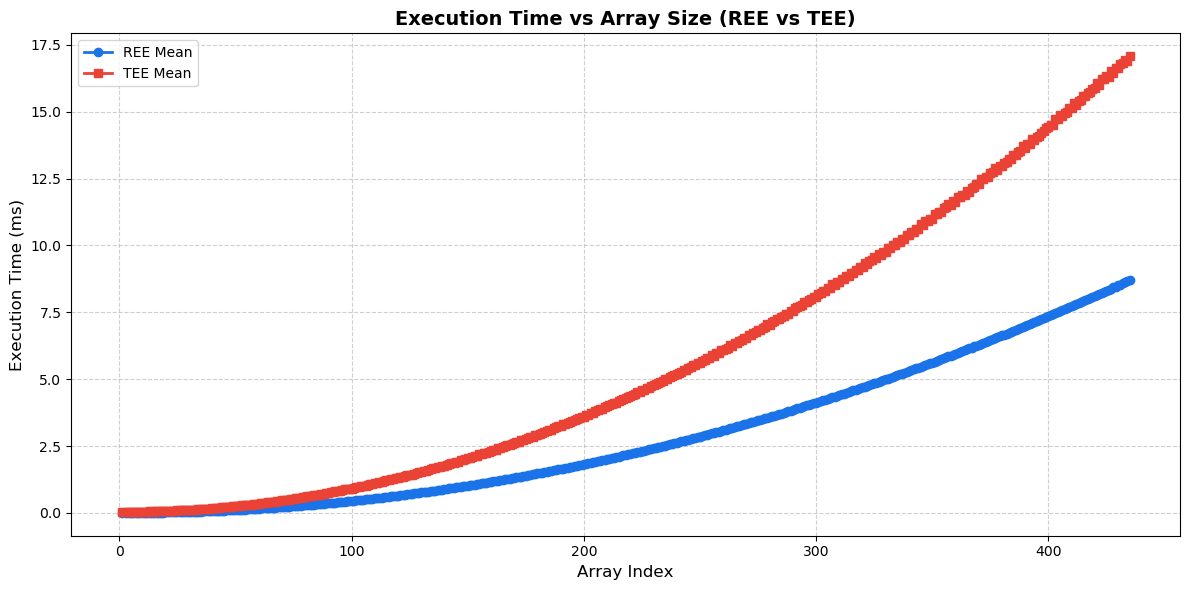

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# 📁 입력/출력 경로
input_file = "/home/avees/tee/output/gemm/all_gemm_stats.csv"
output_file = "/home/avees/tee/output/gemm/all_gemm_plot.png"

# CSV 읽기
df = pd.read_csv(input_file)

# 🔢 숫자 추출 함수
def extract_num(label):
    match = re.search(r"\[(\d+)\]", label)
    return int(match.group(1)) if match else 999999

# 📊 REE / TEE 분리
df_ree = df[df["label"].str.contains("REE")].copy()
df_tee = df[df["label"].str.contains("TEE")].copy()

# 🔁 정렬용 숫자 컬럼 추가
df_ree["sort_key"] = df_ree["label"].apply(extract_num)
df_tee["sort_key"] = df_tee["label"].apply(extract_num)

# 오름차순 정렬
df_ree = df_ree.sort_values(by="sort_key").reset_index(drop=True)
df_tee = df_tee.sort_values(by="sort_key").reset_index(drop=True)

# x축 (숫자만)
x_ree = df_ree["sort_key"].values
x_tee = df_tee["sort_key"].values

# y축 (mean / std)
y_ree = df_ree["mean"].values
std_ree = df_ree["std"].values
y_tee = df_tee["mean"].values
std_tee = df_tee["std"].values

# 🎨 그래프 설정
plt.figure(figsize=(12, 6))

# REE 라인
plt.plot(x_ree, y_ree, marker='o', color="#1a73e8", linewidth=2, label="REE Mean")
# plt.fill_between(x_ree, y_ree - std_ree, y_ree + std_ree, color="#1a73e8", alpha=0.2, label="REE ±1 Std")

# TEE 라인
plt.plot(x_tee, y_tee, marker='s', color="#ea4335", linewidth=2, label="TEE Mean")
# plt.fill_between(x_tee, y_tee - std_tee, y_tee + std_tee, color="#ea4335", alpha=0.2, label="TEE ±1 Std")

# 제목 및 축
plt.title("Execution Time vs Array Size (REE vs TEE)", fontsize=14, weight="bold")
plt.xlabel("Array Index", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)

# ⚙️ x축 눈금 (100 단위만 표시)
max_x = max(np.max(x_ree), np.max(x_tee))
tick_positions = np.arange(0, max_x + 1, 100)
plt.xticks(tick_positions, [str(int(t)) for t in tick_positions])

# 격자 및 범례
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True)

# 저장 및 표시
plt.tight_layout()
plt.savefig(output_file)
print(f"✅ 그래프 저장 완료: {output_file}")

plt.show()


✅ 그래프 저장 완료: /home/avees/tee/output/gemm/all_gemm_flops_plot.png


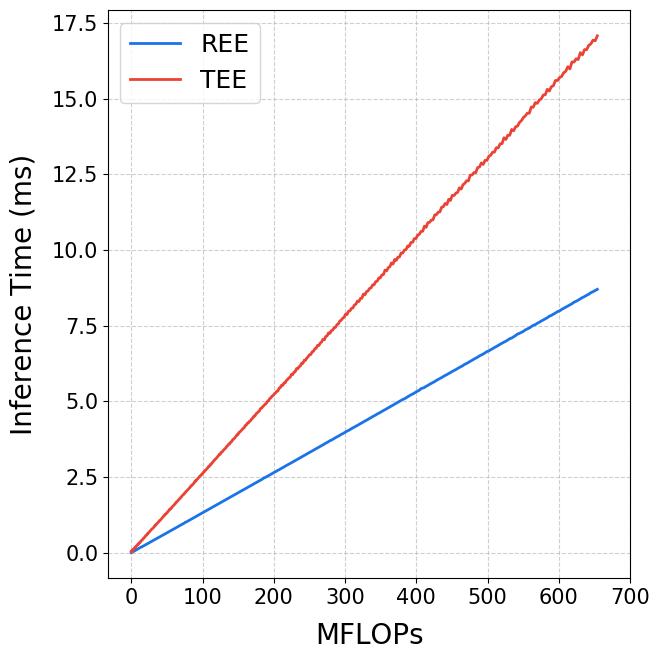

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# 📁 입력/출력 경로
input_file = "/home/avees/tee/output/gemm/all_gemm_stats.csv"
output_file = "/home/avees/tee/output/gemm/all_gemm_flops_plot.png"

# CSV 읽기
df = pd.read_csv(input_file)

# 🔢 [] 안 숫자 추출
def extract_num(label):
    match = re.search(r"\[(\d+)\]", label)
    return int(match.group(1)) if match else 999999

# 📊 REE / TEE 분리
df_ree = df[df["label"].str.contains("REE")].copy()
df_tee = df[df["label"].str.contains("TEE")].copy()

# 🔁 정렬용 숫자 컬럼 추가
df_ree["i"] = df_ree["label"].apply(extract_num)
df_tee["i"] = df_tee["label"].apply(extract_num)

# 정렬
df_ree = df_ree.sort_values(by="i").reset_index(drop=True)
df_tee = df_tee.sort_values(by="i").reset_index(drop=True)

# ✅ FLOPs 계산
C_in = 3
C_out = 64
K = 3
df_ree["FLOPs"] = 2 * (df_ree["i"] ** 2) * C_out * (K * K * C_in)
df_tee["FLOPs"] = 2 * (df_tee["i"] ** 2) * C_out * (K * K * C_in)

# x축 (FLOPs)
x_ree = df_ree["FLOPs"].values
x_tee = df_tee["FLOPs"].values

# y축 (mean)
y_ree = df_ree["mean"].values
y_tee = df_tee["mean"].values

# 🎨 전체 폰트 크기 설정
plt.rcParams.update({
    'font.size': 20,          # 기본 폰트 크기
    'axes.titlesize': 24,     # 제목 크기
    'axes.labelsize': 20,     # 축 라벨 크기
    'xtick.labelsize': 15,    # X축 눈금
    'ytick.labelsize': 15,    # Y축 눈금
    'legend.fontsize': 18,    # 범례
})

# 🎨 그래프 설정
plt.figure(figsize=(7, 7))

plt.plot(x_ree, y_ree, color="#1a73e8", linewidth=2, label="REE")
plt.plot(x_tee, y_tee, color="#ea4335", linewidth=2, label="TEE")


# plt.fill_between(x_ree, y_ree - std_ree, y_ree + std_ree, color="#1a73e8", alpha=0.2, label="REE ±1 Std")

# plt.fill_between(x_tee, y_tee - std_tee, y_tee + std_tee, color="#ea4335", alpha=0.2, label="TEE ±1 Std")

# 제목 및 축
# plt.title("Execution Time vs FLOPs (REE vs TEE)", weight="bold")
plt.xlabel("MFLOPs", labelpad=10)
plt.ylabel("Inference Time (ms)", labelpad=10)

# ✅ x축 눈금을 100 MFLOPs 간격으로 표시
max_flops = max(x_ree.max(), x_tee.max())
xticks = np.arange(0, max_flops + 1e8, 1e8)  # 100 MFLOPs 단위
plt.xticks(xticks, [f"{v/1e6:.0f}" for v in xticks])  # 표시 단위: MFLOPs

# 격자 및 범례
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(output_file, dpi=300)
print(f"✅ 그래프 저장 완료: {output_file}")

plt.show()


✅ 그래프 저장 완료: /home/avees/tee/output/gemm/all_gemm_flops_plot.png


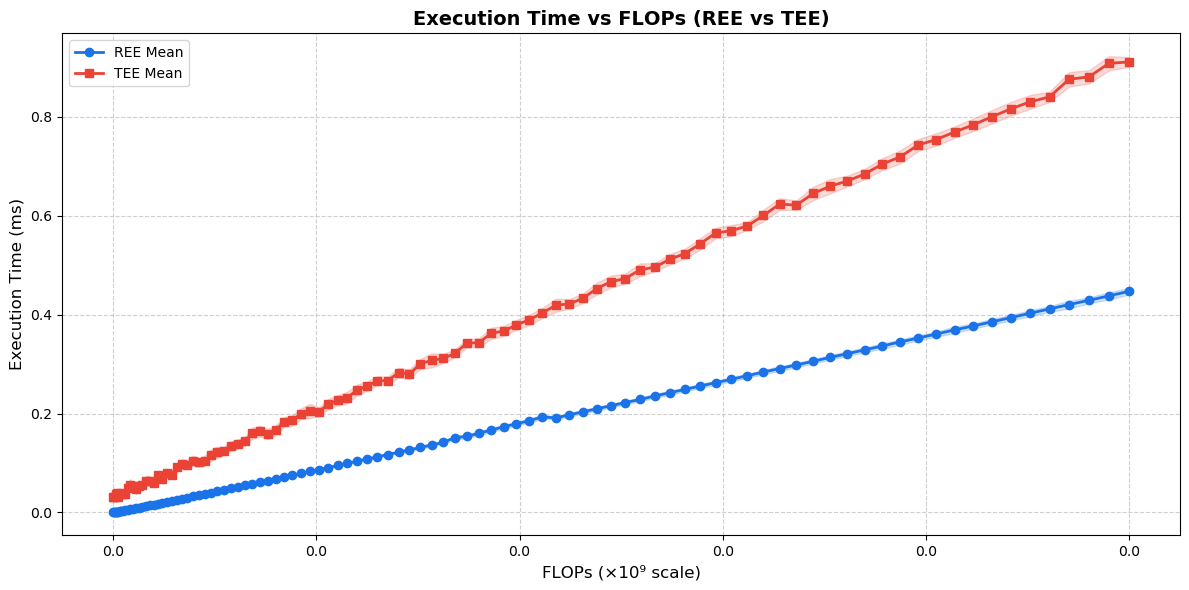

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# 📁 입력/출력 경로
input_file = "/home/avees/tee/output/gemm/all_gemm_stats.csv"
output_file = "/home/avees/tee/output/gemm/all_gemm_flops_plot.png"

# CSV 읽기
df = pd.read_csv(input_file)

# 🔢 [] 안 숫자 추출
def extract_num(label):
    match = re.search(r"\[(\d+)\]", label)
    return int(match.group(1)) if match else 999999

# 📊 REE / TEE 분리
df_ree = df[df["label"].str.contains("REE")].copy()
df_tee = df[df["label"].str.contains("TEE")].copy()

# 🔁 정렬용 숫자 컬럼 추가
df_ree["i"] = df_ree["label"].apply(extract_num)
df_tee["i"] = df_tee["label"].apply(extract_num)

# 정렬
df_ree = df_ree.sort_values(by="i").reset_index(drop=True)
df_tee = df_tee.sort_values(by="i").reset_index(drop=True)

# ✅ 1~100 구간만 필터링
df_ree = df_ree[(df_ree["i"] >= 1) & (df_ree["i"] <= 100)]
df_tee = df_tee[(df_tee["i"] >= 1) & (df_tee["i"] <= 100)]


# ✅ FLOPs 계산 (예: conv with 3x3 kernel, Cin=3, Cout=64)
C_in = 3
C_out = 64
K = 3

df_ree["FLOPs"] = 2 * (df_ree["i"] ** 2) * C_out * (K * K * C_in)
df_tee["FLOPs"] = 2 * (df_tee["i"] ** 2) * C_out * (K * K * C_in)

# x축 (FLOPs)
x_ree = df_ree["FLOPs"].values
x_tee = df_tee["FLOPs"].values

# y축 (mean / std)
y_ree = df_ree["mean"].values
std_ree = df_ree["std"].values
y_tee = df_tee["mean"].values
std_tee = df_tee["std"].values

# 🎨 그래프 설정
plt.figure(figsize=(12, 6))

plt.plot(x_ree, y_ree, marker='o', color="#1a73e8", linewidth=2, label="REE Mean")
plt.fill_between(x_ree, y_ree - std_ree, y_ree + std_ree, color="#1a73e8", alpha=0.2)

plt.plot(x_tee, y_tee, marker='s', color="#ea4335", linewidth=2, label="TEE Mean")
plt.fill_between(x_tee, y_tee - std_tee, y_tee + std_tee, color="#ea4335", alpha=0.2)

# 제목 및 축
plt.title("Execution Time vs FLOPs (REE vs TEE)", fontsize=14, weight="bold")
plt.xlabel("FLOPs (×10⁹ scale)", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)

# FLOPs 단위 조정 (10⁹)
plt.xticks(np.linspace(0, max(x_ree.max(), x_tee.max()), 6),
           [f"{v/1e9:.1f}" for v in np.linspace(0, max(x_ree.max(), x_tee.max()), 6)])

# 격자 및 범례
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(output_file)
print(f"✅ 그래프 저장 완료: {output_file}")

plt.show()


REE 근사식: y = 1.313e+01 * x (b=0)
TEE 근사식: y = 2.604e+01 * x + 0.0172
호출 오버헤드(TEE b - REE b): 0.017225 ms
연산 오버헤드 비율(a_TEE / a_REE): 1.984x
✅ 그래프 저장 완료: /home/avees/tee/output/gemm/all_gemm_flops_fit_origin.png


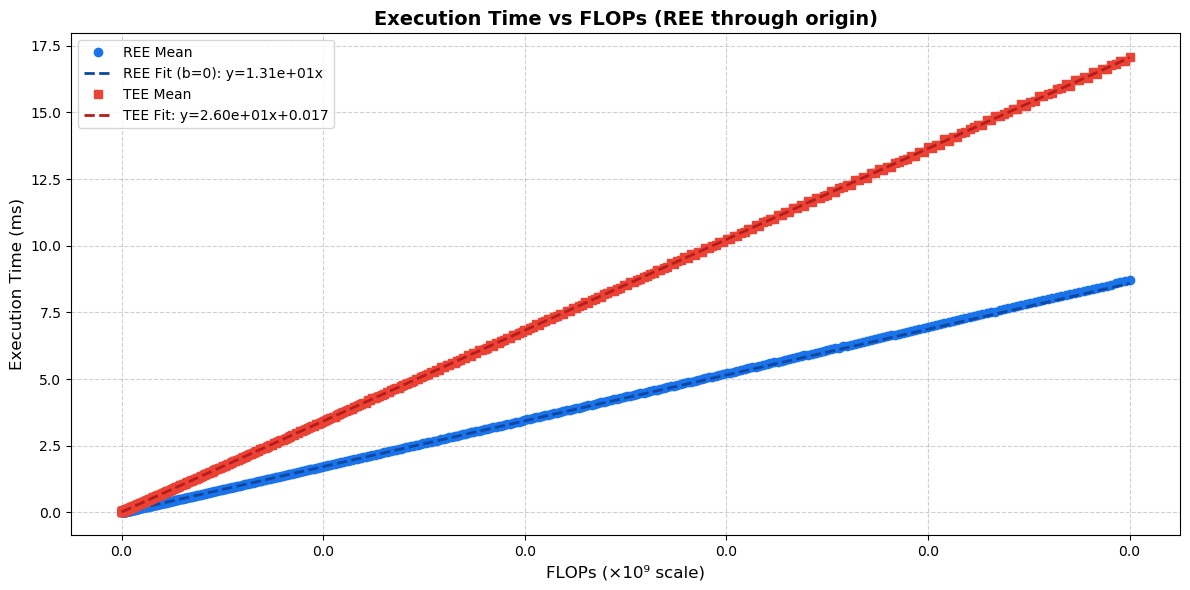

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# 📁 입력/출력 경로
input_file = "/home/avees/tee/output/gemm/all_gemm_stats.csv"
output_file = "/home/avees/tee/output/gemm/all_gemm_flops_fit_origin.png"

# CSV 읽기
df = pd.read_csv(input_file)

# 🔢 [] 안 숫자 추출
def extract_num(label):
    match = re.search(r"\[(\d+)\]", label)
    return int(match.group(1)) if match else 999999

# 📊 REE / TEE 분리
df_ree = df[df["label"].str.contains("REE")].copy()
df_tee = df[df["label"].str.contains("TEE")].copy()

# 🔁 정렬용 숫자 컬럼 추가
df_ree["i"] = df_ree["label"].apply(extract_num)
df_tee["i"] = df_tee["label"].apply(extract_num)

# 정렬
df_ree = df_ree.sort_values(by="i").reset_index(drop=True)
df_tee = df_tee.sort_values(by="i").reset_index(drop=True)

# ✅ FLOPs 계산 (예: conv with 3x3 kernel, Cin=3, Cout=64)
C_in = 3
C_out = 64
K = 3
df_ree["FLOPs"] = (2 * (df_ree["i"] ** 2) * C_out * (K * K * C_in)) / 1e9
df_tee["FLOPs"] = (2 * (df_tee["i"] ** 2) * C_out * (K * K * C_in)) / 1e9

x_ree = df_ree["FLOPs"].values
y_ree = df_ree["mean"].values
x_tee = df_tee["FLOPs"].values
y_tee = df_tee["mean"].values

# ✅ REE 근사: 원점 통과, 평균 비율 방식
a_ree = np.mean(y_ree / x_ree)
b_ree = 0
fit_ree = a_ree * x_ree

# ✅ TEE 근사: 일반 회귀
a_tee, b_tee = np.polyfit(x_tee, y_tee, 1)
fit_tee = a_tee * x_tee + b_tee

print(f"REE 근사식: y = {a_ree:.3e} * x (b=0)")
print(f"TEE 근사식: y = {a_tee:.3e} * x + {b_tee:.4f}")
print(f"호출 오버헤드(TEE b - REE b): {b_tee - b_ree:.6f} ms")
print(f"연산 오버헤드 비율(a_TEE / a_REE): {a_tee / a_ree:.3f}x")

# 🎨 그래프
plt.figure(figsize=(12, 6))

# REE
plt.plot(x_ree, y_ree, 'o', color="#1a73e8", label="REE Mean")
plt.fill_between(x_ree, y_ree - std_ree, y_ree + std_ree, color="#1a73e8", alpha=0.2)
plt.plot(x_ree, fit_ree, '--', color="#0d47a1", linewidth=2, label=f"REE Fit (b=0): y={a_ree:.2e}x")

# TEE
plt.plot(x_tee, y_tee, 's', color="#ea4335", label="TEE Mean")
plt.fill_between(x_tee, y_tee - std_tee, y_tee + std_tee, color="#ea4335", alpha=0.2)
plt.plot(x_tee, fit_tee, '--', color="#b71c1c", linewidth=2, label=f"TEE Fit: y={a_tee:.2e}x+{b_tee:.3f}")

# 제목 및 축
plt.title("Execution Time vs FLOPs (REE through origin)", fontsize=14, weight="bold")
plt.xlabel("FLOPs (×10⁹ scale)", fontsize=12)
plt.ylabel("Execution Time (ms)", fontsize=12)

# FLOPs 단위 축 조정
plt.xticks(np.linspace(0, max(x_ree.max(), x_tee.max()), 6),
           [f"{v/1e9:.1f}" for v in np.linspace(0, max(x_ree.max(), x_tee.max()), 6)])

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", frameon=True)

plt.tight_layout()
plt.savefig(output_file)
print(f"✅ 그래프 저장 완료: {output_file}")

plt.show()
